# Personal Data Protection Method Development

The purpose of this work is to develop a method (algorithm) for converting clients personal data for the insurance company Slash-and-Burn in such a way that it would be difficult to restore personal information.  
At the same time, it is necessary to protect personal data in such a way to not affect the quality of ML models after data conversion.

## Exploring the Data

In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt

sns.set(rc={'figure.figsize':(14, 8)}, palette='Set2', font_scale=1.25)

### Data description

**sex** - client's gender  
**age** - client's age  
**salary** - salary  
**family_members** - number of family members  
**insurance_claim** - number of insured events  

### Data Loading and Exploring

In [2]:
data = pd.read_csv('datasets/insurance.csv')

In [3]:
data.head()

,sex,age,salary,family_members,insurance_claim
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              5000 non-null   int64  
 1   age              5000 non-null   float64
 2   salary           5000 non-null   float64
 3   family_members   5000 non-null   int64  
 4   insurance_claim  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
data.describe()

,sex,age,salary,family_members,insurance_claim
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


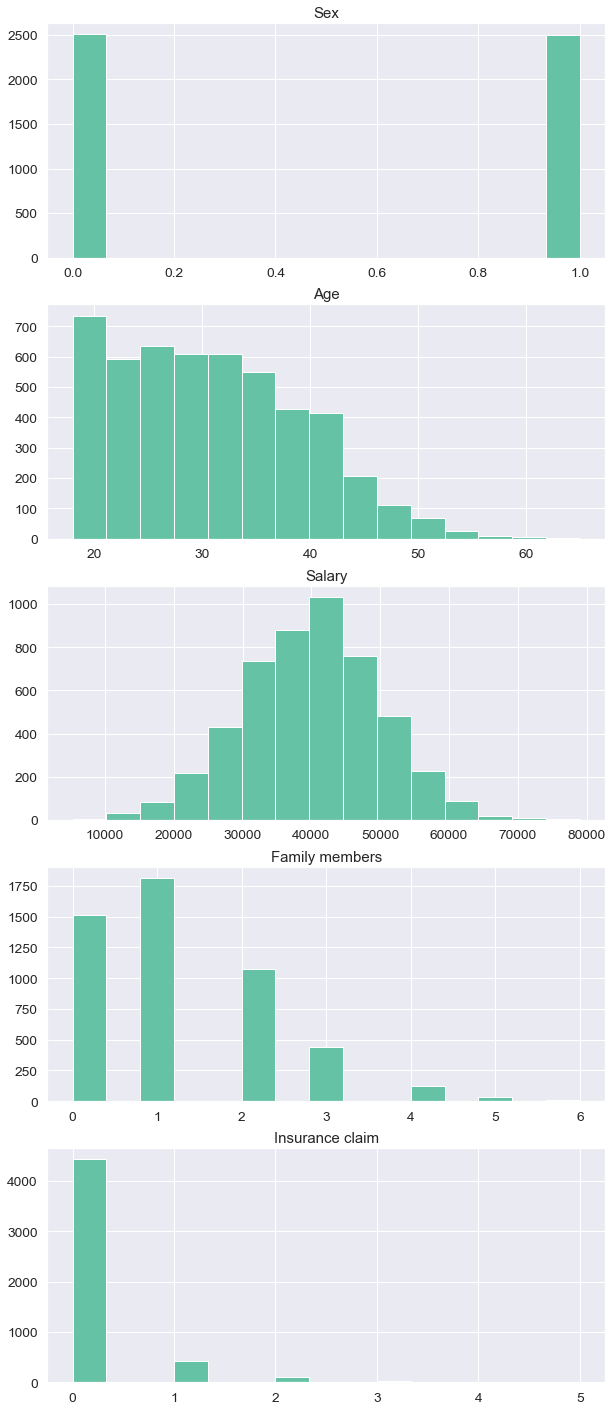

In [6]:
fig, axes = plt.subplots(5, 1)

for ax, column in zip(axes, data.columns):
    ax.hist(data[column], bins=15)
    ax.title.set_text(column.capitalize().replace('_', ' '))
fig.set_figheight(25)
fig.set_figwidth(10)

plt.show();

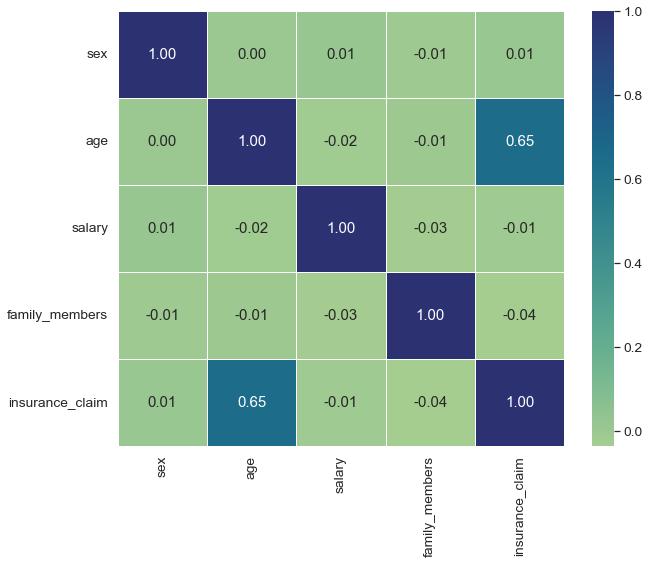

In [7]:
plt.subplots(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap="crest", linewidth=.5);

There is a correlation between age and insurance payments (target attribute). There is no multicollinarity between characters.

**Conclusion**
The table has 5000 rows and 5 columns. There is no missing data. The data types are set correctly. Significant correlations between the signs are not observed. Data preprocessing is not required.

## Matrix multiplication

In our project we are using a linear regression model for predictions. We need to find out whether the multiplication of a feature matrix and an invertible matrix of the appropriate size will affect the quality of the model's predictions.

**Answer:** Multiplying the feature matrix by the reversible matrix will not affect the quality of the model prediction.

**Proof:**


Model Prediction:

$a = X\cdot w$ 

The minimum MSE value is obtained when the weights are equal:

$w = (X^T \cdot X)^{-1}\cdot X^T\cdot Y$
    
Model prediction with feature multiplication by an invertible matrix:

$a' = X\cdot P\cdot w'$ 
 

Next, we express $a'$ in terms of $w'$:
    
$
w' = ((X\cdot P)^T \cdot (X\cdot P))^{-1}\cdot (X\cdot P)^T\cdot Y 
$     

We obtain:

$a' = X\cdot P\cdot ((X\cdot P)^T \cdot (X\cdot P))^{-1}\cdot (X\cdot P)^T\cdot Y$

Using the following property of inverse matrices:

$(A\cdot B)^{-1} = B^{-1}\cdot A^{-1}$,

Then make a transformation:

$a' = X\cdot P\cdot P^{-1}\cdot((X\cdot P)^{T}\cdot X)^{-1} (X\cdot P)^T\cdot Y$

Since the transposed product of matrices is equal to the product of the transposed matrices taken in reverse order, and the product of a matrix and its inverse matrix results in the identity matrix, then:

$a' = X\cdot E\cdot((X\cdot P)^{T}\cdot X)^{-1} P^T\cdot X^T\cdot Y$ 

We can reduce the identity matrix, because multiplying a matrix by the identity matrix does not change it. At the same time, we will perform one more transformation based on the property of transonic matrix multiplication:

$a' = X\cdot (P^T\cdot X^T\cdot X)^{-1} P^T\cdot X^T\cdot Y$

Let's apply again the property of inverse matrix multiplication:

$a' = X\cdot (X^T\cdot X)^{-1}\cdot (P^T)^{-1}\cdot P^T\cdot X^T\cdot Y$

Multiplying $(P^T)^{-1}\cdot P^T$ we get the identity matrix:

$a' = X\cdot (X^T\cdot X)^{-1}\cdot E\cdot X^T\cdot Y$

$a' = X\cdot (X^T\cdot X)^{-1}\cdot X^T\cdot Y$

Since $w = (X^T\cdot X)^{-1}\cdot X^T\cdot Y$, then:

$a' = X\cdot w$, that is:

$a' = a$, 

This means that the predictions are equal in both cases, which was required to be proved.

Thus:

$X\cdot P\cdot w' = X\cdot w$,

$w = P\cdot w'$

## Conversion algorithm

**Algorithm**  

The proposed data transformation algorithm includes three transformation stages:
1. Multiplication of the training dataset by an invertible matrix.
2. Standardization of features.
3. Shuffling array columns in a predetermined order.

**Explanation**

1. Since the multiplication of the training dataset by a size-compatible square matrix does not affect the quality of the predictions of the linear regression model, we can take multiplication by an invertible matrix as the basis for the data transformation algorithm.
2. After the multiplication operation, we can also standardize the features. Thus, all signs will have approximately the same range of values, and it will be even more problematic to restore personal data from such a table.
3. After that, we can also shuffle the feature columns of the dataset in a certain order, because when training the model, the initial order of the features is not important, the main thing is that this order is the same for the training sample and the data set for prediction.

**Algorithm implementation**

We implement the algorithm through the PersonalDataProcessing class.

In [8]:
class PersonalDataProcessing:
    
    def __init__(self):
        """
        Object initialization.
        We declare an object of the StandardScaler class 
        to carry out the standardization of features.
        """
        self.scaler = StandardScaler()  
    
    
    def fit(self, features):
        """
        The fit method function. Takes the features of the training sample as input
        """
        # Remember the width of the matrix  
        matrix_size = features.shape[1]  
        # Create a list of column indices of the features array, 
        # and then shuffle it in random order
        self.permutation = list(range(matrix_size))  
        random.shuffle(self.permutation)
        
        # Creating a matrix and checking it for negotiability 
        self.rev_matrix = np.random.normal(size=(matrix_size, matrix_size))
        while np.linalg.det(self.rev_matrix) == 0:  
            self.rev_matrix = np.random.normal(size=(matrix_size, matrix_size))  

        self.scaler.fit(features.values)  # fitting the scaler
        
        return None
    
    
    def transform(self, features, *args):
        """
        The transform method function. Takes an array of features as input, 
        returns an array of converted values
        Chain of transformations: multiplication of an array of features 
        by an invertible matrix, standardization,
        shuffling array columns in a predetermined order
        """
        features = features.dot(self.rev_matrix)
        features = self.scaler.transform(features.values)
        features = features[:, self.permutation]
        
        return features
    
    
    def fit_transform(self, features, *args):  
        """
        fit_transform method function. Accepts features as input, 
        returns converted features.
        Combines fit and trasform methods.
        Implemented so that the class can be used in Pipeline.
        """
        self.fit(features)
        return self.transform(features, *args)
        

## Algorithm test

In [9]:
# Extracting features and target from Data
X = data.drop('insurance_claim', axis=1)
y = data['insurance_claim']

Since the algorithm uses standardization, and when checking we will use cross-validation, it should be carried out using a pipeline.

Let's get the results of the R2 metric when training the model on the initial data.

In [10]:
model = LinearRegression()
scores_0 = cross_val_score(model, X, y, scoring='r2')

In [11]:
scores_0.mean()

0.42311376915907745

Now we will get the R2 metric of the model using the data transformation algorithm.

In [12]:
model = LinearRegression()
pdp = PersonalDataProcessing()
pipe = make_pipeline(pdp, model)
scores_1 = cross_val_score(pipe, X, y, scoring='r2')

In [13]:
scores_1.mean()

0.42311376915449106

In [14]:
f'R2 metric on initial data: {scores_0.mean()}'

'R2 metric on initial data: 0.42311376915907745'

In [15]:
f'R2 metric on processed data: {scores_1.mean()}'

'R2 metric on processed data: 0.42311376915449106'

Let's see what the converted data looks like.

In [16]:
pdp = PersonalDataProcessing()
X_processed = pdp.fit_transform(X)

In [17]:
pd.DataFrame(X_processed)

,0,1,2,3
0,134948.555006,2991.929660,21728.663143,6.021468
1,103386.539304,2289.416552,16660.513218,3.669955
2,57134.550187,1263.154183,9208.492151,0.224108
3,113452.447246,2516.512385,18259.251955,4.420260
4,71011.881829,1571.824207,11437.335870,1.258045
...,...,...,...,...
4995,97128.156248,2152.523521,15641.229266,3.204007
4996,142564.885224,3162.349279,22947.940268,6.588920
4997,92230.768950,2044.674680,14847.042623,2.839216
4998,88967.018584,1971.612790,14325.452345,2.596233


**Conclusion**

Based on the results of the check, we can conclude that the implemented algorithm performs its function of changing personal data, making it difficult to restore them. At the same time, the algorithm does not reduce the quality of machine learning on the transformed data. The quality of training on the original and transformed data differs in the level of error in working with float numbers in Python.

## Summary

The following steps were taken during the project:

- Data analysis. No problems were found in the data.
- Mathematically proved the thesis that the multiplication of the feature matrix by the reversible matrix does not affect the quality of the model prediction. The relationship between the weights of the model trained on the original and transformed features is established.
- A three-stage algorithm for the transformation of personal data has been proposed and implemented:
    1. Multiplication of an array of features by an invertible matrix
    2. Standardization of feature values
    3. Shuffling feature array columns in a predetermined order
- The algorithm has been tested. As a result, according to the R2 metric, the difference between the model trained on the original and transformed features is within the computational error.